<a href="https://colab.research.google.com/github/dekoska/computer-vision-course/blob/main/02_document-scanner/02_document_scanner_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab.patches import cv2_imshow
from skimage.filters import threshold_local
import numpy as np
from numpy.linalg import norm
import imutils
import cv2

(600, 450, 3)


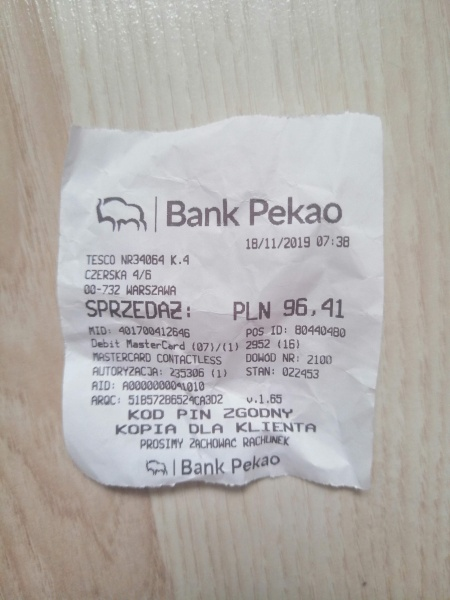

In [ ]:
img = cv2.imread('paragon_4.jpg')
print(img.shape)
cv2_imshow(img)

(500, 375, 3)


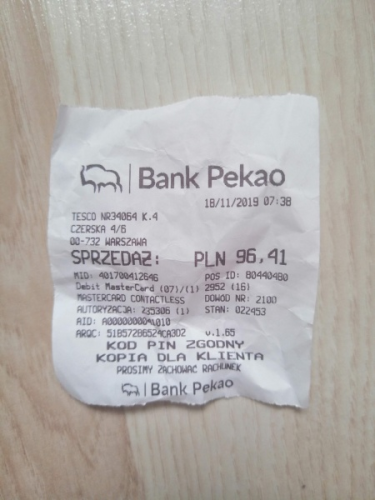

In [ ]:
original_image = img.copy()
ratio = img.shape[0] / 500.0
img = imutils.resize(img, height=500)
print(img.shape)
cv2_imshow(img)

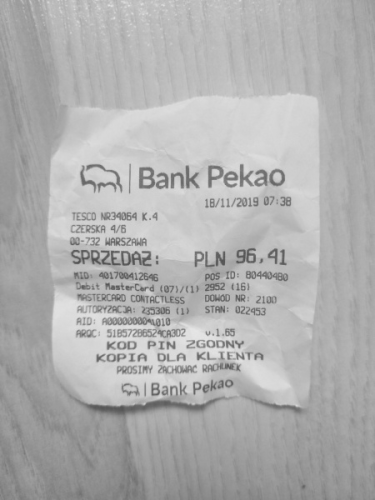

In [ ]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)

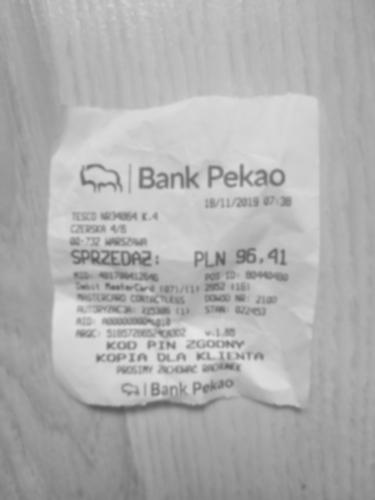

In [ ]:
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
cv2_imshow(blurred_image)

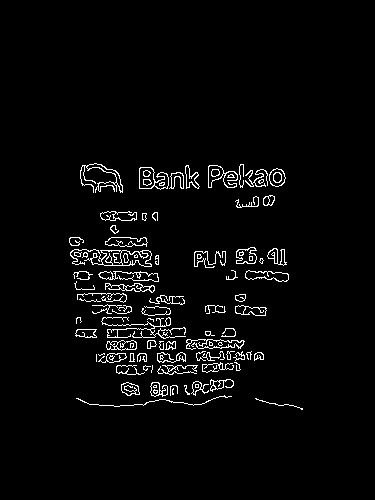

In [ ]:
edges = cv2.Canny(blurred_image, threshold1=75, threshold2=200)
cv2_imshow(edges)

In [ ]:
contours = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
print(f'liczba wykrytych konturow: {len(contours)}')
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

for contour in contours:
  print(len(contour))

liczba wykrytych konturow: 181
185
46
64
58
45


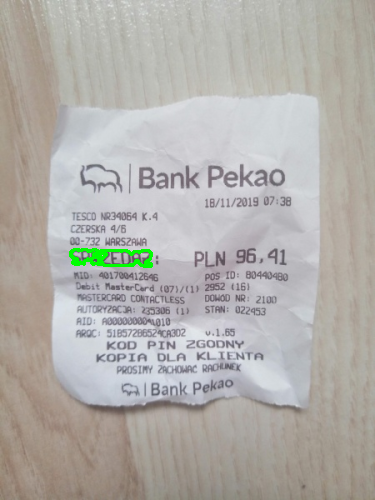

In [ ]:
cnt1 = cv2.drawContours(img.copy(), [contours[0]], contourIdx=-1, color=(0, 255, 0), thickness=2)
cv2_imshow(cnt1)

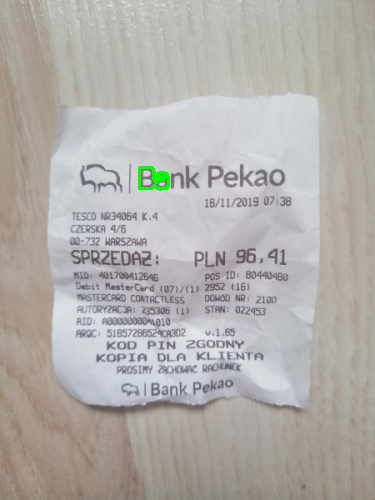

In [ ]:
cnt2 = cv2.drawContours(img.copy(), [contours[1]], contourIdx=-1, color=(0, 255, 0), thickness=2)
cv2_imshow(cnt2)

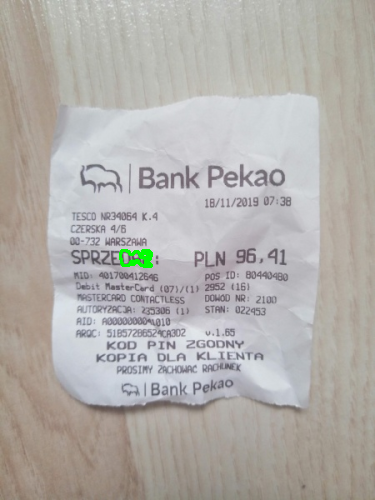

In [ ]:
cnt3 = cv2.drawContours(img.copy(), [contours[2]], contourIdx=-1, color=(0, 255, 0), thickness=2)
cv2_imshow(cnt3)

In [ ]:
for contour in contours:
  peri = cv2.arcLength(contour, closed=True)
  approx = cv2.approxPolyDP(curve=contour, epsilon=0.02 * peri, closed=True)

  if(len(approx) == 4):
    screen_contour = approx
    break

print(screen_contour)

[[[ 92  94]]

 [[ 66 345]]

 [[317 356]]

 [[288 114]]]


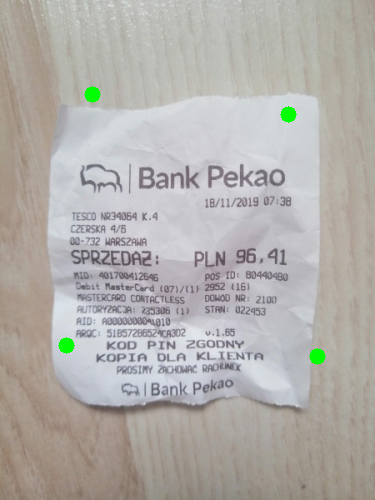

In [ ]:
cv2.drawContours(img, screen_contour, contourIdx=-1, color=(0, 255, 0), thickness=15)
cv2_imshow(img)

In [ ]:
points = screen_contour.reshape(4, 2)
points = points * ratio
points

array([[110.4, 112.8],
       [ 79.2, 414. ],
       [380.4, 427.2],
       [345.6, 136.8]])

In [ ]:
rectangle = np.zeros((4,2), dtype='float32')
rectangle

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [ ]:
total = points.sum(axis=1)

rectangle[0] = points[np.argmin(total)]
rectangle[2] = points[np.argmax(total)]
rectangle

array([[110.4, 112.8],
       [  0. ,   0. ],
       [380.4, 427.2],
       [  0. ,   0. ]], dtype=float32)

In [ ]:
difference = np.diff(points, axis=1)

rectangle[1] = points[np.argmin(difference)]
rectangle[3] = points[np.argmax(difference)]
rectangle

array([[110.4, 112.8],
       [345.6, 136.8],
       [380.4, 427.2],
       [ 79.2, 414. ]], dtype=float32)

In [ ]:
(a,b,c,d) = rectangle

#dlugosc euklidesowa
width1 = norm(c-d)
width2 = norm(b-a)
max_width = int(max(width1, width2))
print(max_width)

height1 = norm(b-c)
height2 = norm(a-d)
max_height = int(max(height1, height2))
print(max_height)

301
302


In [ ]:
verticles = np.array([
                     [0,0],
                     [max_width-1, 0],
                     [max_width-1, max_height-1],
                     [0, max_height-1]], dtype='float32')

verticles

array([[  0.,   0.],
       [300.,   0.],
       [300., 301.],
       [  0., 301.]], dtype=float32)

In [ ]:
M = cv2.getPerspectiveTransform(rectangle, verticles)
M

array([[ 1.30047708e+00,  1.34710795e-01, -1.58768050e+02],
       [-1.40439919e-01,  1.37631123e+00, -1.39743344e+02],
       [-3.10264938e-04,  1.00569064e-03,  1.00000000e+00]])

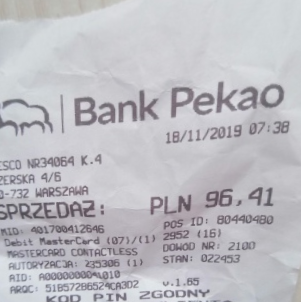

In [ ]:
#przeksztalcanie dokumentu do obrazu
out = cv2.warpPerspective(original_image, M=M, dsize=(max_width, max_height))
cv2_imshow(out)

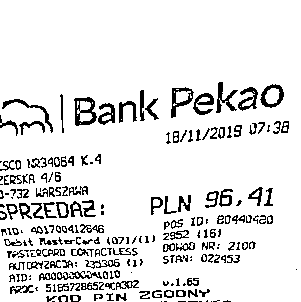

In [ ]:
out = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)

#obliczanie maski na podstawie sasiedztwa pikseli
T = threshold_local(image=out, block_size=11, offset=10, method='gaussian')
out = (out > T).astype('uint8') * 255

cv2_imshow(out)